# Basic demonstration 

This notebook it intended to demonstrate some of the basic concepts in the new version of of the rompy code

- Separation of 'runtime' from 'config' - more on this later
- Modular
    - There are a number of core objects 
- Pydantic throughout
    - Strong typing
    - Clearly defined APIs
    - Built in validators
- Declaritive
    - The entire configuration to run the model is passed at intantiation. 
    - The core wrapper is a pycallable, making it play nicely with downstream workflow packages (e.g. airflow)
    - Can still be run proceduraly. 
- Separation of intake components. 
    - Common filters now available as a separate import. 
    - Data is provdided to the wrapper as large lazy datasets, and data selection is done based on runtime period and grid spatial extents
    - Substantially reduced the fricton to hook up a different dataset
    - Filters are still available to use in intake drivers where appropriate (e.g. where constructing nowcasts from many forecasts becomes memory prohibitive to do lazily)

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
# Import some core objects
from rompy.swan import SwanConfig, SwanDataGrid, SwanGrid
from rompy.core import TimeRange, ModelRun, BaseConfig, BaseGrid, RegularGrid
from rompy.swan.data import SwanDataGrid
import xarray as xr
import numpy as np
import tempfile
import os
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
ModelRun??

Init signature:
ModelRun(
    *,
    run_id: str = 'run_id',
    period: rompy.core.time.TimeRange = TimeRange(start=datetime.datetime(2020, 2, 21, 4, 0), end=datetime.datetime(2020, 2, 24, 4, 0), duration=datetime.timedelta(days=3), interval=datetime.timedelta(seconds=900), include_end=True),
    output_dir: str = 'simulations',
    config: rompy.core.config.BaseConfig = BaseConfig(model_type='base', template='/source/rompy/rompy/templates/base', checkout='main'),
) -> None
Source:        
class ModelRun(RompyBaseModel):
    """A base class for all models"""

    run_id: str = Field("run_id", description="The run id")
    period: TimeRange = Field(
        TimeRange(
            start=datetime(2020, 2, 21, 4),
            end=datetime(2020, 2, 24, 4),
            interval="15M",
        ),
        description="The time period to run the model",
    )
    output_dir: str = Field("simulations", description="The output directory")
    config: BaseConfig = Field(BaseConfig(), description=

In [4]:
TimeRange??

Init signature:
TimeRange(
    *,
    start: Optional[datetime.datetime] = None,
    end: Optional[datetime.datetime] = None,
    duration: Union[str, datetime.timedelta, NoneType] = None,
    interval: Union[str, datetime.timedelta, NoneType] = '1h',
    include_end: bool = True,
) -> None
Source:        
class TimeRange(BaseModel):
    """
    A time range object

    Examples
    --------
    >>> from rompy import TimeRange
    >>> tr = TimeRange(start="2020-01-01", end="2020-01-02")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=None, interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=timedelta(days=1), interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d", interval="1h")
    >>> tr
    TimeRange(start=datetime.datetime(2

In [5]:
BaseConfig??

Init signature:
BaseConfig(
    *,
    model_type: Literal['base'] = 'base',
    template: Optional[str] = '/source/rompy/rompy/templates/base',
    checkout: Optional[str] = 'main',
    **extra_data: Any,
) -> None
Source:        
class BaseConfig(RompyBaseModel):
    """A base class for all templates"""

    model_type: Literal["base"] = "base"
    template: Optional[str] = Field(
        description="The path to the model template",
        default="/source/rompy/rompy/templates/base",
    )
    checkout: Optional[str] = Field(
        description="The git branch to use if the template is a git repo",
        default="main",
    )

    class Config:
        extra = "allow"

    def __call__(self, runtime):
        return self.dict()
File:           /source/rompy/rompy/core/config.py
Type:           ModelMetaclass
Subclasses:     SwanConfig

In [6]:
BaseGrid??

Init signature:
BaseGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['base'] = 'base',
) -> None
Source:        
class BaseGrid(RompyBaseModel):
    """
    An object which provides an abstract representation of a grid in some geographic space

    This is the base class for all Grid objects. The minimum representation of a grid are two
    NumPy array's representing the vertices or nodes of some structured or unstructured grid,
    its bounding box and a boundary polygon. No knowledge of the grid connectivity is expected.
    """

    x: Optional[NDArray] = Field(description="A 1D array of x coordinates")
    y: Optional[NDArray] = Field(description="A 1D array of y coordinates")
    grid_type: Literal["base"] = "base"

    @property
    def minx(self) -> float:
        return np.nanmin(self.x)

    @property
    def maxx(self) -> float:
        return np.nanmax(self.x)



In [7]:
RegularGrid??

Init signature:
RegularGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['regular'] = 'regular',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
) -> None
Source:        
class RegularGrid(BaseGrid):
    """
    An object which provides an abstract representation of a regular grid in
    some geographic space
    """

    grid_type: Literal["regular"] = Field(
        "regular", description="Type of grid, must be 'regular'"
    )
    x0: Optional[float] = Field(None, description="X coordinate of the grid origin")
    y0: Optional[float] = Field(None, description="Y coordinate of the grid origin")
    rot: Optional[float] = Field(
        0.0, description="Rotation angle of the grid in degrees"
    )
    d

In [8]:
from rompy.swan import SwanDataGrid, SwanGrid, SwanConfig

In [9]:
SwanGrid??


Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

In [10]:
SwanConfig??

Init signature:
SwanConfig(
    *,
    model_type: Literal['swan'] = 'swan',
    template: str = '/source/rompy/rompy/templates/swan',
    checkout: Optional[str] = 'main',
    grid: rompy.swan.grid.SwanGrid,
    spectral_resolution: rompy.swan.config.SwanSpectrum = SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36),
    forcing: rompy.swan.config.ForcingData = ForcingData(bottom=None, wind=None, current=None, boundary=None),
    physics: rompy.swan.config.SwanPhysics = SwanPhysics(friction='MAD', friction_coeff=0.1),
    outputs: rompy.swan.config.Outputs = Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
)),
    spectra_file: str = 'boundary.spec',
    **extra_data: Any,
) -> None
Source:        
class SwanConfig(BaseConfig):
    """SWAN configuration"""

    grid: SwanGrid = Field(description="The model grid for the SWAN run")
    model_type: Literal["swan"] = F

In [37]:
from rompy.swan.config import SwanSpectrum, ForcingData, SwanPhysics, Outputs, SwanDataGrid

In [12]:
SwanSpectrum??

Init signature:
SwanSpectrum(
    *,
    fmin: float = 0.0464,
    fmax: float = 1.0,
    nfreqs: int = 31,
    ndirs: int = 36,
) -> None
Source:        
class SwanSpectrum(Spectrum):
    """SWAN Spectrum"""

    @property
    def cmd(self):
        return f"CIRCLE {self.ndirs} {self.fmin} {self.fmax} {self.nfreqs}"
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [13]:
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    path: Optional[str] = None,
    url: Optional[str] = None,
    catalog: Optional[str] = None,
    dataset: Optional[str] = None,
    args: Optional[dict] = {},
    params: Optional[dict] = {},
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    xarray_kwargs: Optional[dict] = {},
    netcdf_kwargs: Optional[dict] = {'mode': 'w', 'format': 'NETCDF4'},
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field", type=str, default=None)
    var: st

In [14]:
SwanPhysics??

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Source:        
class SwanPhysics(RompyBaseModel):
    """Container class represting configuraable SWAN physics options"""

    friction: str = Field(
        default="MAD", description="The type of friction, either 'MAD' or 'TODO'."
    )
    friction_coeff: float = Field(
        default=0.1,
        description="The coefficient of friction for the given surface and object.",
    )

    @validator("friction")
    def validate_friction(cls, v):
        if v not in ["MAD", "OTHER", "ANDANOTHER"]:
            raise ValueError(
                "friction must be one of MAD, OTHER or ANDANOTHER"
            )  # TODO Raf to add actual friction options
        return v

    @validator("friction_coeff")
    def validate_friction_coeff(cls, v):
        # TODO Raf to add sensible friction coeff range
        if float(v) > 1:
            raise ValueError("friction_coeff must be less than 1")
        if fl

In [15]:
ForcingData??

Init signature:
ForcingData(
    *,
    bottom: rompy.swan.data.SwanDataGrid | None = None,
    wind: rompy.swan.data.SwanDataGrid | None = None,
    current: rompy.swan.data.SwanDataGrid | None = None,
    boundary: rompy.swan.data.SwanDataGrid | None = None,
) -> None
Source:        
class ForcingData(RompyBaseModel):
    bottom: SwanDataGrid | None = None  # TODO Raf should probably be required?
    wind: SwanDataGrid | None = None
    current: SwanDataGrid | None = None
    boundary: SwanDataGrid | None = None

    def get(self, grid, runtime):
        ret = []
        for forcing in self:
            if forcing[1]:
                logger.info(f"\t processing {forcing[0]} forcing")
                forcing[1]._filter_grid(grid)
                forcing[1]._filter_time(runtime.period)
                ret.append(forcing[1].get(runtime.staging_dir, grid))
        return "\n".join(ret)

    def __str__(self):
        ret = ""
        for forcing in self:
            if forcing[1]:
      

In [16]:
SwanGrid??

Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

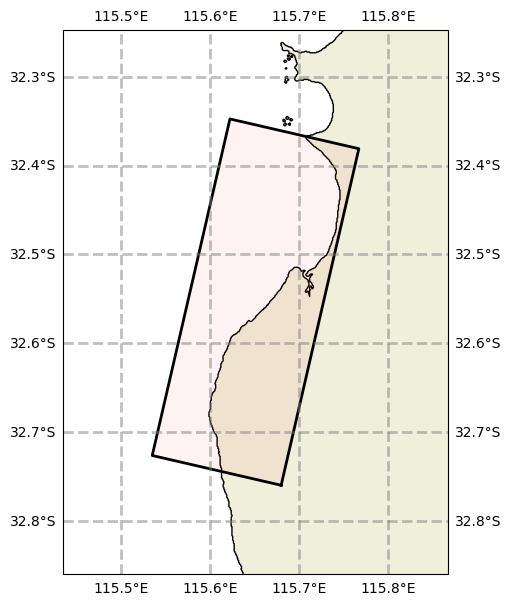

In [38]:
grid = SwanGrid(x0=115.68, y0=-32.76, dx=0.001, dy=0.001, nx=390, ny=150, rot=77)
grid.plot()

In [18]:
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    path: Optional[str] = None,
    url: Optional[str] = None,
    catalog: Optional[str] = None,
    dataset: Optional[str] = None,
    args: Optional[dict] = {},
    params: Optional[dict] = {},
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    xarray_kwargs: Optional[dict] = {},
    netcdf_kwargs: Optional[dict] = {'mode': 'w', 'format': 'NETCDF4'},
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field", type=str, default=None)
    var: st

In [63]:
# Create a dummy netcdf data
from rompy.swan import SwanDataGrid
os.makedirs("simulations/test_swantemplate/datasets", exist_ok=True)
datagrid = SwanGrid(x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.001, dy=0.001, exc=-99.0)

def nc_bathy(bottom=datagrid):
    # touch temp netcdf file
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "bathy.nc")
    bbox = bottom.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], wind_grid.dy)
    lon = np.arange(bbox[0], bbox[2], wind_grid.dx)
    ds = xr.Dataset(
        {
            "depth": xr.DataArray(
                np.random.rand(bottom.ny, bottom.nx),
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return SwanDataGrid(
        id="bottom", path=source, z1="depth", var="BOTTOM", latname="lat", lonname="lon"
    )


def nc_data_source(wind_grid=datagrid):
    wind_grid = SwanGrid(
        x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.001, dy=0.001, exc=-99.0
    )
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "wind_inputs.nc")

    bbox = wind_grid.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], wind_grid.dy)
    lon = np.arange(bbox[0], bbox[2], wind_grid.dx)

    ds = xr.Dataset(
        {
            "u": xr.DataArray(
                np.random.rand(10, wind_grid.ny, wind_grid.nx),
                dims=["time", "lat", "lon"],
                coords={
                    "time": pd.date_range("2000-01-01", periods=10),
                    "lat": lat,
                    "lon": lon,
                },
            ),
            "v": xr.DataArray(
                np.random.rand(10, wind_grid.ny, wind_grid.nx),
                dims=["time", "lat", "lon"],
                coords={
                    "time": pd.date_range("2020-02-21", periods=10),
                    "lat": lat,
                    "lon": lon,
                },
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return SwanDataGrid(id="wind", var="WIND", path=source, z1="u", z2="v")

(<Figure size 1000x384.615 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

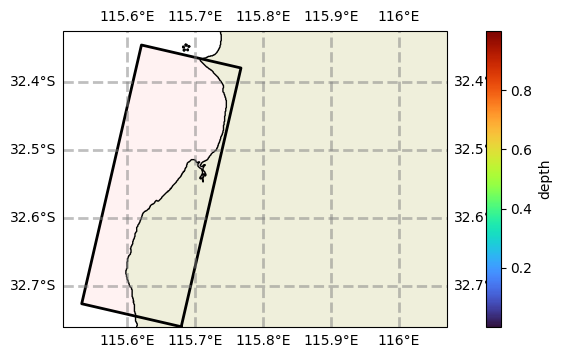

In [64]:
bathy = nc_bathy()
bathy.plot(param='depth', fscale=10, model_grid=datagrid)


In [57]:
# retrive the bathy data
bathy.get('./')

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: ./bottom.grd


"INPGRID BOTTOM REG 115.68 -32.76 0.0 390 150 0.0010000000000000015 0.0009999999999999905 EXC -99.0\nREADINP BOTTOM 1.0 'bottom.grd' 3 FREE\n"

In [25]:
# retive the wind data
wind = nc_data_source()
wind.get('./')

INFO:rompy.swan.data:	Writing wind to ./wind.grd


"INPGRID WIND REG 115.68 -32.76 0.0 390 150 0.0010000000000000015 0.0009999999999999905 NONSTATION 20000101.000000 9303.157894736842 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n"

In [ ]:
forcing = ForcingData(wind=wind, bottom=bathy)
forcing.get??

Signature: forcing.get(grid, runtime)
Docstring: <no docstring>
Source:   
    def get(self, grid, runtime):
        ret = []
        for forcing in self:
            if forcing[1]:
                logger.info(f"\t processing {forcing[0]} forcing")
                forcing[1]._filter_grid(grid)
                forcing[1]._filter_time(runtime.period)
                ret.append(forcing[1].get(runtime.staging_dir, grid))
        return "\n".join(ret)
File:      /source/rompy/rompy/swan/config.py
Type:      method

In [ ]:
try:
    physics = SwanPhysics(friction='INVALID')
except ValueError as e:
    logger.warning(e)

friction
  friction must be one of MAD, OTHER or ANDANOTHER (type=value_error)


In [ ]:
physics = SwanPhysics()
print(physics.cmd)

GEN3 WESTH 0.000075 0.00175
BREAKING
FRICTION MAD 0.1

TRIADS

PROP BSBT
NUM ACCUR 0.02 0.02 0.02 95 NONSTAT 20



In [ ]:
Outputs??

Init signature:
Outputs(
    *,
    grid: rompy.swan.config.GridOutput = GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']),
    spec: rompy.swan.config.SpecOutput = SpecOutput(period=None, locations=OutputLocs
),
) -> None
Source:        
class Outputs(RompyBaseModel):
    """Outputs for SWAN"""

    grid: GridOutput = GridOutput()
    spec: SpecOutput = SpecOutput()
    _datefmt: str = "%Y%m%d.%H%M%S"

    @property
    def cmd(self):
        out_intvl = "1.0 HR"  # Hardcoded for now, need to get from time object too TODO
        ret = "OUTPUT OPTIONS BLOCK 8\n"
        ret += f"BLOCK 'COMPGRID' HEADER 'outputs/swan_out.nc' LAYOUT 1 {' '.join(self.grid.variables)} OUT {self.grid.period.start.strftime(self._datefmt)} {out_intvl}\n"
        ret += "\n"
        if self.spec.locations:
            ret += f"POINTs 'pts' FILE 'out.loc'\n"
        ret += f"SPECout 'pts' SPEC2D ABS 'outputs/spec_out.nc' OUTPUT {self.spec.period.start.strftim

In [ ]:
outputs = Outputs()
outputs
# outputs.cmd

Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
))

In [ ]:
run = ModelRun(
        run_id="test_swantemplate",
        period=TimeRange(start=datetime(2020, 2, 21, 4), end=datetime(2020, 2, 24, 4)),
        output_dir="simulations",
        config=SwanConfig(
            grid=grid,
            physics=physics,
            forcing=forcing,
            outputs=outputs,
        )
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

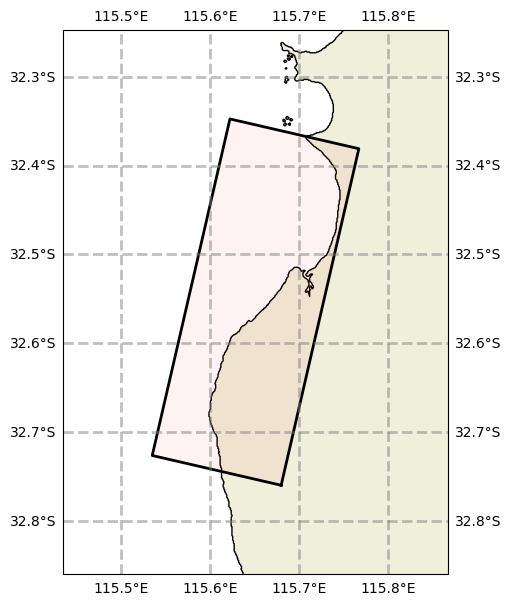

In [ ]:
run.config.grid.plot()

In [ ]:
print(run.config.forcing.get(grid=run.config.grid, runtime=run))

INFO:rompy.swan.config:	 processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 processing wind forcing
INFO:rompy.swan.data:	Writing wind to simulations/test_swantemplate/wind.grd


INPGRID BOTTOM REG 115.68 -32.76 0.0 187 150 0.0009999999999999872 0.0009999999999999905 EXC -99.0
READINP BOTTOM 1.0 'bottom.grd' 3 FREE

INPGRID WIND REG 115.68 -32.76 77.0 389 149 0.001 0.001 NONSTATION 20200222.000000 24.0 HR
READINP WIND 1 'wind.grd' 3 0 1 0 FREE



In [ ]:
run.config.outputs.spec.locations

OutputLocs

In [ ]:
run()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom: simulations/test_swantemplate/datasets/bathy.nc
wind: simulations/test_swantemplate/datasets/wind_inputs.nc

physics: friction='MAD' friction_coeff=0.1
outputs: Outputs:
	Grid:
		variables: DEPTH UBOT HSIGN HSWELL DIR TPS TM01 WIND
	Spec
		locations: 


template: /source/rompy/rompy/templates/swan

INFO:rompy.core.model:Template used to generate model: /source/rompy/rompy/templates/swan
INFO:rompy.swan.config:	 processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 processing wind forcing
INFO:rompy.swan.data

'/source/rompy/notebooks/simulations/test_swantemplate'

In [ ]:
run.config.forcing.bottom.path

'simulations/test_swantemplate/datasets/bathy.nc'